# Load Libraries

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import matplotlib
from torch import optim
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder as Dataset
from torchvision import transforms
from sklearn.metrics import confusion_matrix

# Load dataset

To load the dataset, please download from the following google drive link and store in the top-level driectory of your google drive.

https://drive.google.com/drive/folders/18Rl6OSqn04ac-0UZgod_UfA77OmRfYZ7?usp=sharing

In [2]:
# Import data from my google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Extract Dataset on Google Drive

# Visualize the Data

In [7]:
# Create Dataset with resize
dataset = Dataset(root = '/content/drive/MyDrive/1000images', transform = transforms.Resize([100,100]))
a = dataset.find_classes('/content/drive/MyDrive/1000images')[1]
classmap={}
for key, value in a.items():
  classmap[value] = key
class_datasets = {}
classes = np.zeros([39])
for i in range(39):
  class_datasets[i] = []
for d in dataset:
  classes[d[1]]+=1
  if len(class_datasets[d[1]]) < 3:
    class_datasets[d[1]].append(d[0])

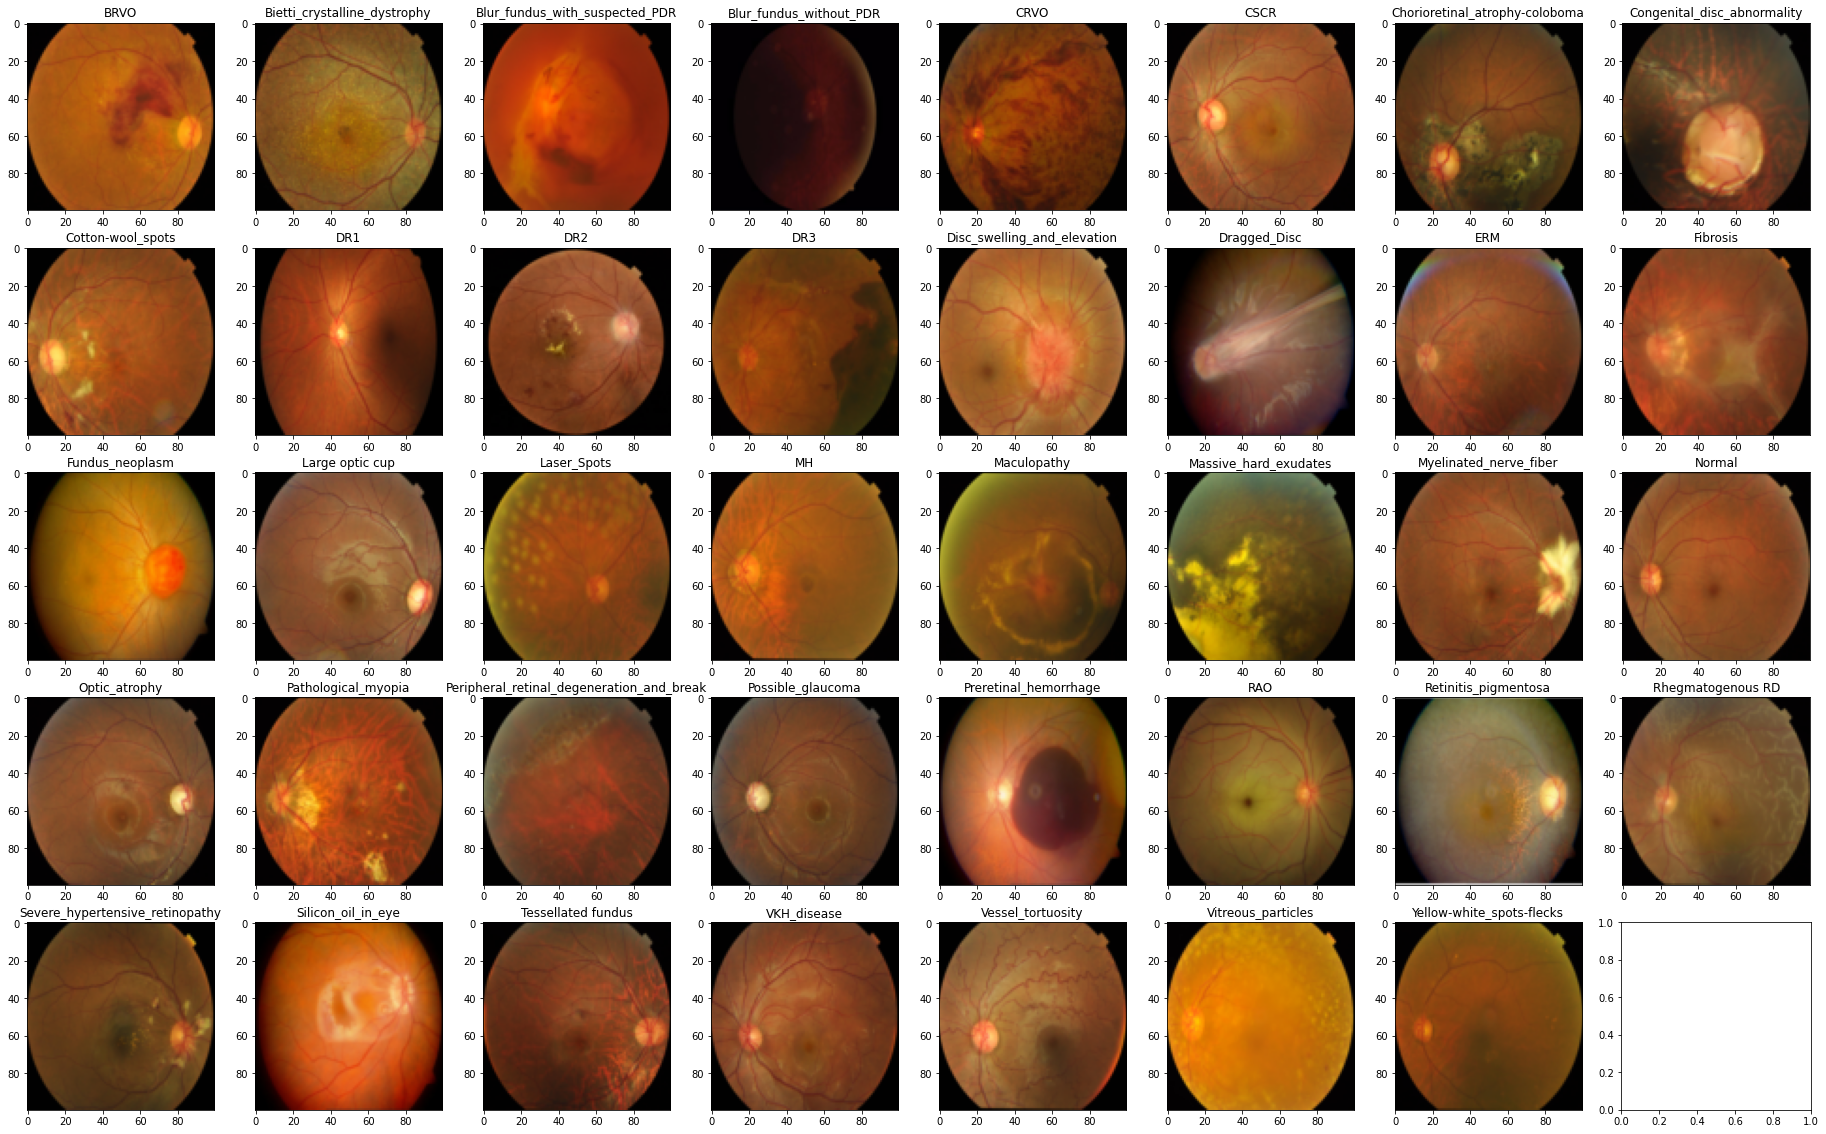

In [8]:
# Show an example of each class
_, axes = plt.subplots(5,8, figsize=(32, 20))
axes = axes.flatten()
for i in range(39):
    axes[i].imshow(class_datasets[i][0])
    axes[i].set_title(classmap[i]) 
plt.show()
plt.savefig('class_visualisation.png')

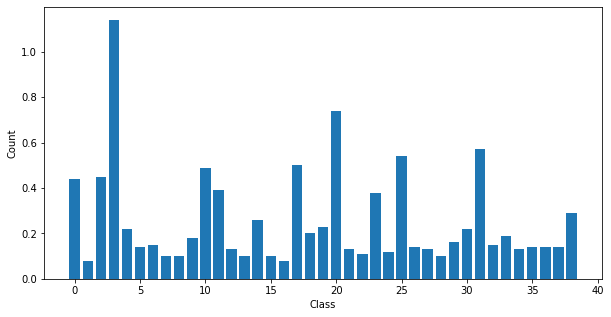

25.641025641025642 15.0 21.58879954084356 8.0 114.0


In [9]:
plt.figure(figsize=[10,5])
plt.bar(np.arange(39), height=classes/100.0)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print(np.mean(classes), np.median(classes), np.std(classes), np.min(classes), np.max(classes))

# Create Dataloader, make splits

In [3]:
trans = transforms.Compose([transforms.Resize([80,80]), 
                            transforms.ToTensor()])

dataset = Dataset(root = '/content/drive/MyDrive/1000images',
                  transform=trans)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [700, 100, 200], generator=torch.Generator().manual_seed(0))

#data = torch.concat([d[0].unsqueeze(0) for d in train_dataset], dim=0)
#std, mean = torch.std_mean(data, dim=[0,2,3])
#print(std, mean)
std, mean = [0.2333, 0.1491, 0.0802], [0.4617, 0.2690, 0.1068]


train_trans = transforms.Compose([transforms.Resize([80,80]), 
                                  transforms.RandomCrop(64,64),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomAutocontrast(),
                                  transforms.RandomRotation(degrees=(-15, 15)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)])

eval_trans = transforms.Compose([transforms.Resize([80,80]),
                                 transforms.CenterCrop([64,64]),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)])

train_dataset.dataset.transform = train_trans
val_dataset.dataset.transform = eval_trans
test_dataset.dataset.transform = eval_trans


# Define Model

In [4]:
class Ensemble(nn.Module):
  def __init__(self, models) -> None:
    super(Ensemble, self).__init__()

    self.models = nn.ModuleList(models)
  
  def forward(self, feats):
    return torch.concat([model(feats).unsqueeze(0) for model in self.models], dim=0)

# Track Loop

In [8]:
import time

# Define training and test loops
def train(model: nn.Module, device: str, train_loader: data.DataLoader, 
          criterion: nn.Module, optimizer: torch.optim.Optimizer, epoch: int):
    model.train()
    data_len = len(train_loader)
    for batch_idx, _data in enumerate(train_loader):
        #Get data
        inputs, targets = _data

        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero-out grads
        optimizer.zero_grad()

        # Get model outputs
        logits = model(inputs)  # (batch,)
        probs = nn.functional.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).cpu().numpy()
        targs = targets.cpu().numpy()
        acc = np.mean(np.equal(preds, targs))*100.0

        # Compute loss
        loss = criterion(logits.squeeze(), targets)

        # Backprop
        loss.backward()

        # Update model
        optimizer.step()


        # Print loss
        if batch_idx % 5 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch, batch_idx, data_len,
                       100. * batch_idx / len(train_loader), loss.item(), acc))

def test(model: nn.Module, device: str, test_loader: data.DataLoader,
         criterion: nn.Module, epoch: int,  name: str, ensemble=False,fivecrop=False,tencrop=False):
    model.eval()
    test_loss = 0
    preds, targs = [], []

    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(test_loader):

            #Get data
            inputs, targets = _data

            # Move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            # Get model outputs
            if fivecrop or tencrop:
              inputs = inputs.reshape([-1, 3, 64, 64])
            logits = model(inputs)  # (batch,)
            probs = nn.functional.softmax(logits, dim=-1).squeeze()

            if ensemble:
              probs = torch.mean(probs, dim=0).squeeze()

            if tencrop:
              probs = torch.mean(probs.reshape([-1, 10, 39]), dim=1).squeeze()
            if fivecrop:
              probs = torch.mean(probs.reshape([-1, 5, 39]), dim=1).squeeze()
            
            # Get Predictions
            pred = torch.argmax(probs, dim=-1)
            preds.append(pred)
            targs.append(targets)

            # Compute loss
            logits = torch.log(probs+1e-10)
            loss = criterion(logits, targets)

            # Print loss
            test_loss += loss.item() / len(test_loader)

    preds = torch.concat(preds).cpu().numpy()
    targs = torch.concat(targs).cpu().numpy()

    acc = np.mean(np.equal(preds, targs))

    print(f'{name} Epoch: {epoch}, Loss: {loss}, Accuracy: {acc*100}% .')

    # Return targets and model preds for later analysis
    return loss, acc, preds, targs

# Setup and Train

In [6]:
torch.manual_seed(7)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print("Using device:", device)

# Hyperparameters
hparams = {
    "learning_rate":  1e-3, #Keep init LR as high as possible without destroying model
    "weight_decay": 0.0, # Weight decay ended up being detrimental
    "batch_size":  32, # Small batch size acts as pretty strong regularisation
    "epochs": 15
}


# Define training and test data loaders
kwargs = {'num_workers': 4, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, **kwargs)

# Load up the correct transforms
train_dataset.dataset.transform = train_trans
val_dataset.dataset.transform = eval_trans

# Construct loaders
kwargs = {'num_workers': 1, 'pin_memory': True}
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, **kwargs)


# Construct model
models = []
for i in range(5):
  model = torchvision.models.resnet18(num_classes=39)
  model.to(device)
  models.append(model)

# Define loss
criterion = nn.CrossEntropyLoss()

best_models = []
# Train the model
for m in range(len(models)):
  # Define optimizer and LR scheduler
  optimizer = optim.AdamW(models[m].parameters(), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'])
  scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.2, last_epoch= -1, verbose=False) # Lower LR 5X every 20-30 epochs
  for i in range(1):
    cur_best_loss = -np.inf
    for epoch in range(1, hparams['epochs'] + 1):
        train(models[m], device, train_loader, criterion, optimizer, epoch=epoch)
        scheduler.step()
        vloss, vacc, _, _ = test(models[m], device, val_loader, criterion, epoch, name='Val')
        tloss, tacc, _, _ = test(models[m], device, test_loader, criterion, epoch, name='Test')
        print('')
        if vacc > cur_best_loss:
          cur_best_loss = vacc
          print("Saving new best model. Best Validation Accuracy:", cur_best_loss)
          torch.save(model[m], f'model_{m}.pt')


Using device: cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 1 [0/22 (0%)]	Loss: 3.897145	Accuracy: 0.00%
Train Epoch: 1 [5/22 (23%)]	Loss: 3.558029	Accuracy: 12.50%
Train Epoch: 1 [10/22 (45%)]	Loss: 2.966842	Accuracy: 28.12%
Train Epoch: 1 [15/22 (68%)]	Loss: 3.207154	Accuracy: 18.75%
Train Epoch: 1 [20/22 (91%)]	Loss: 2.911417	Accuracy: 21.88%
Val Epoch: 1, Loss: 2.4463248252868652, Accuracy: 24.0% .
Test Epoch: 1, Loss: 3.4222018718719482, Accuracy: 24.5% .

Saving new best model. Best Validation Accuracy: 0.24
Train Epoch: 2 [0/22 (0%)]	Loss: 2.042368	Accuracy: 53.12%
Train Epoch: 2 [5/22 (23%)]	Loss: 2.418126	Accuracy: 40.62%
Train Epoch: 2 [10/22 (45%)]	Loss: 3.044016	Accuracy: 31.25%
Train Epoch: 2 [15/22 (68%)]	Loss: 2.052448	Accuracy: 43.75%
Train Epoch: 2 [20/22 (91%)]	Loss: 2.651752	Accuracy: 28.12%
Val Epoch: 2, Loss: 1.706915020942688, Accuracy: 28.999999999999996% .
Test Epoch: 2, Loss: 4.211483001708984, Accuracy: 29.5% .

Saving new best model. Best Validation Accuracy: 0.29
Train Epoch: 3 [0/22 (0%)]	Loss: 2.528840

In [ ]:
# Eval Models
torch.manual_seed(7)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print("Using device:", device)

# Load single models
eval_models = []
for i in range(5):
  model = torch.load(f'model_{i}.pt')
  model.to(device)
  model.eval()
  eval_models.append(model)
ensemble = Ensemble(eval_models)

val_dataset.dataset.transform = eval_trans
test_dataset.dataset.transform = eval_trans

kwargs = {'num_workers': 1, 'pin_memory': True}
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, **kwargs)

# Evaluare single models
losses, accs = 0.0, 0.0
for model in eval_models:
  tloss, tacc, tpreds, ttargs = test(model, device, test_loader, criterion, epoch, name='Test')
  losses+=tloss/5.0
  accs+=tacc*100.0/5.0

print(f"Single Model Accuracy: {accs} and NLLs: {losses}.")

# Evaluate ensemblea
vloss, vacc, vpreds, vtargs = test(ensemble, device, val_loader, criterion, epoch, name='Val', ensemble=True)
tloss, tacc, tpreds, ttargs = test(ensemble, device, test_loader, criterion, epoch, name='Test', ensemble=True)

preds = np.concatenate([vpreds, tpreds])
targs = np.concatenate([vtargs, ttargs])

cm_ens = confusion_matrix(targs,preds)

# Evaluate 5 Crop-Ensemble
# Load up 5-crop transforms

eval_trans_ens = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize([80,80]),
                                 transforms.FiveCrop([64,64]),
                                 transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])),
                                 transforms.Normalize(mean, std)])

val_dataset.dataset.transform = eval_trans_ens
test_dataset.dataset.transform = eval_trans_ens

# Construct data loaders
kwargs = {'num_workers': 1, 'pin_memory': True}
val_eloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True}
test_eloader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, **kwargs)

vloss, vacc, vpreds, vtargs = test(ensemble, device, val_eloader, criterion, epoch, name='Val', ensemble=True, fivecrop=True)
tloss, tacc, tpreds, ttargs = test(ensemble, device, test_eloader, criterion, epoch, name='Test', ensemble=True, fivecrop=True)

preds = np.concatenate([vpreds, tpreds])
targs = np.concatenate([vtargs, ttargs])

cm_5c = confusion_matrix(targs,preds)

# Evaluate 10 Crop-Ensemble
# Load up 10-crop transforms

eval_trans_ens = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize([80,80]),
                                 transforms.TenCrop([64,64]),
                                 transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])),
                                 transforms.Normalize(mean, std)])

val_dataset.dataset.transform = eval_trans_ens
test_dataset.dataset.transform = eval_trans_ens

# Construct data loaders
kwargs = {'num_workers': 1, 'pin_memory': True}
val_eloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False, **kwargs)

kwargs = {'num_workers': 1, 'pin_memory': True}
test_eloader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, **kwargs)

vloss, vacc, vpreds, vtargs = test(ensemble, device, val_eloader, criterion, epoch, name='Val', ensemble=True, tencrop=True)
tloss, tacc, tpreds, ttargs = test(ensemble, device, test_eloader, criterion, epoch, name='Test', ensemble=True, tencrop=True)

preds = np.concatenate([vpreds, tpreds])
targs = np.concatenate([vtargs, ttargs])

cm_10c = confusion_matrix(targs,preds)


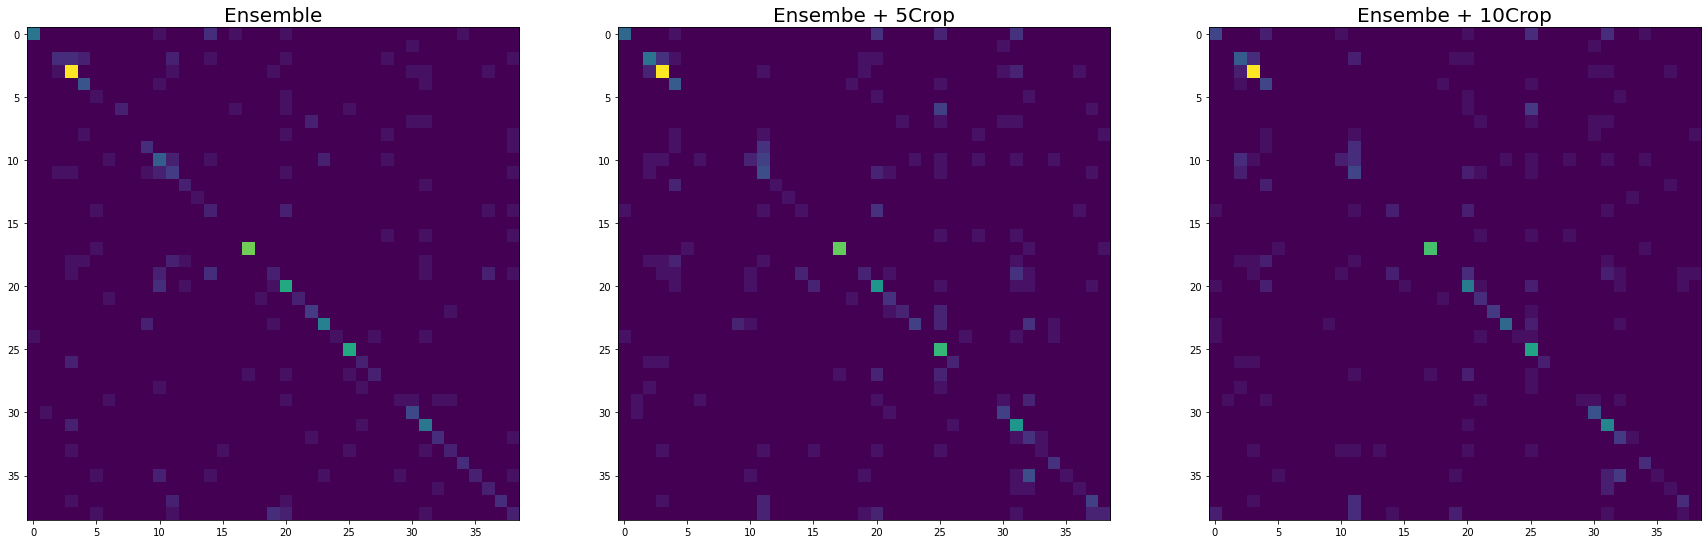

In [32]:
# Generate Confusion Matrix Image
_, axes = plt.subplots(1,3, figsize=(30, 10))
axes = axes.flatten()
cms = [cm_ens, cm_5c, cm_10c]
cm_names = ['Ensemble', 'Ensembe + 5Crop', 'Ensembe + 10Crop']
for i in range(3):
    axes[i].imshow(cms[i])
    axes[i].set_title(cm_names[i], fontsize=20) 
#plt.show()
plt.savefig('confusion_matrices.png')

# Write-up



## Data Analysis

The data used is a subset of the retinopathy classification dataset obtained from Kaggle (https://www.kaggle.com/datasets/linchundan/fundusimage1000). The data contains 1000 fundus images and 39 associate medical conditions, including images of healthy eyes. The goal the state of the fundus in each image into healthy or one of 38 other different medical conditions.

While the dataset is very small, the images are quite large, and approximately square. To make this task manageable with resources available on google colab I resized all images to be 80x80 pixels.

Visualizing examples of all 39 classes, we can see several properties in the dataset:
- There is left-right symmetry (for left and right eyes). This means that we can use random horizontal flips as a data augmentation.
- The image already covers a little more than the entire eye, and most salient features are in the center. Thus suggests that we can operate using random cropping during training and center cropping during evaluation.
- The images tend to not be pefectly aligned - there is minor rotation around the center of the image. This suggests that we can also use small roatinons as data augmentation. 
- Finally, the images vary in brightness and color. This suggests both that the images need to be normalized.


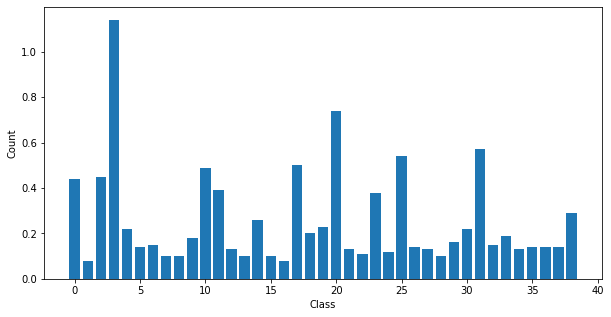

In [31]:
from IPython.display import Image
Image('class_prior.png')

Analysing the distribution of classes, we can see that it is uneven. Some classes are clearly far more numerous in the data than others. The dataset statistics are as follows:
- Mean number of samples per class: 25.6 
- Median number of samples per class: 15 
- Standard Devuation of number of samples per class: 21.6 
- Miniumum / Maximum number of examples per class: 8 / 114

Clearly, the dataset is biased towards some classes and not others. Overall, this represents a challenging learning task, both due to the small number of examples as well as the biased distribuion of classes in the dataset. 



## Pre-processing
I chosee a 70 - 10 - 20 train - val - test split. All images were reized to a size of 80x80 pixels. While this is much smaller than the original size, which was ~2000x2000, it would be unmanageable to process such large files in a colab environment. Using larger resolution would undoubtedly yield better results.

The following transformation were used on the data during training:
- Random 64x64 Crop
- Random horizontal flip
- Random rotation by +/- 15 degrees
- Random contrast
- Noramlization by mean and std learned on training data

The following transformation were applied furing evaluation:
- Center 64x64 crop
- Noramlization by mean and std learned on training data

## Model Choice

I examine a ResNet18 model, which is a somewhat old, but good, and importantly lean, model architecture.

Additionally, as the amount of training data is very limited, I also make use of ensembles which are known to yield improvements in predictive performance and make use of the high variance of neural models when trained on small datasets.

Additionally, I examine test-time data augmentation in the form of 5 and 10 crop ensembles. Here, instead of using the central crop, corner crops as well as their horizontally flipped counterparts are used, respectively. In some works this was shown to yield further improvements on top of Deep Ensembles. 

## Model Analysis

Here, we can see both the model Accuracies:

|          | Single | +Ensmeble | +5-Crop | +10-crop |
|----------|--------|----------|--------|---------|
| ResNet18 |  47.5%      |   56.5%       |    45.0%    |  47.5%       |

and the test-set negative log-likelihoods:

|          | Single | +Ensmeble | +5-Crop | +10-crop |
|----------|--------|----------|--------|---------|
| ResNet18 |  3.06      |  2.66        |    2.26    |   2.31      |


The results show that using an Ensemble of 5 models can improve the performance by almost 10%! Curiously, using test-time data augmentation hurts performance by about 10% as well. Judging by the fundus images, it may be the case that the top corner crops may miss crucial information which is contained closer to the bottom of the image, which prevents the model from yielding informative predictions. 

However, both ensembling and test-time data augmentation improve the negative los-likelihoods on the test data. It is likely the case that while test-time data augmentation yields better calibrated uncertainties even on the errors (model makes less-confident errors).


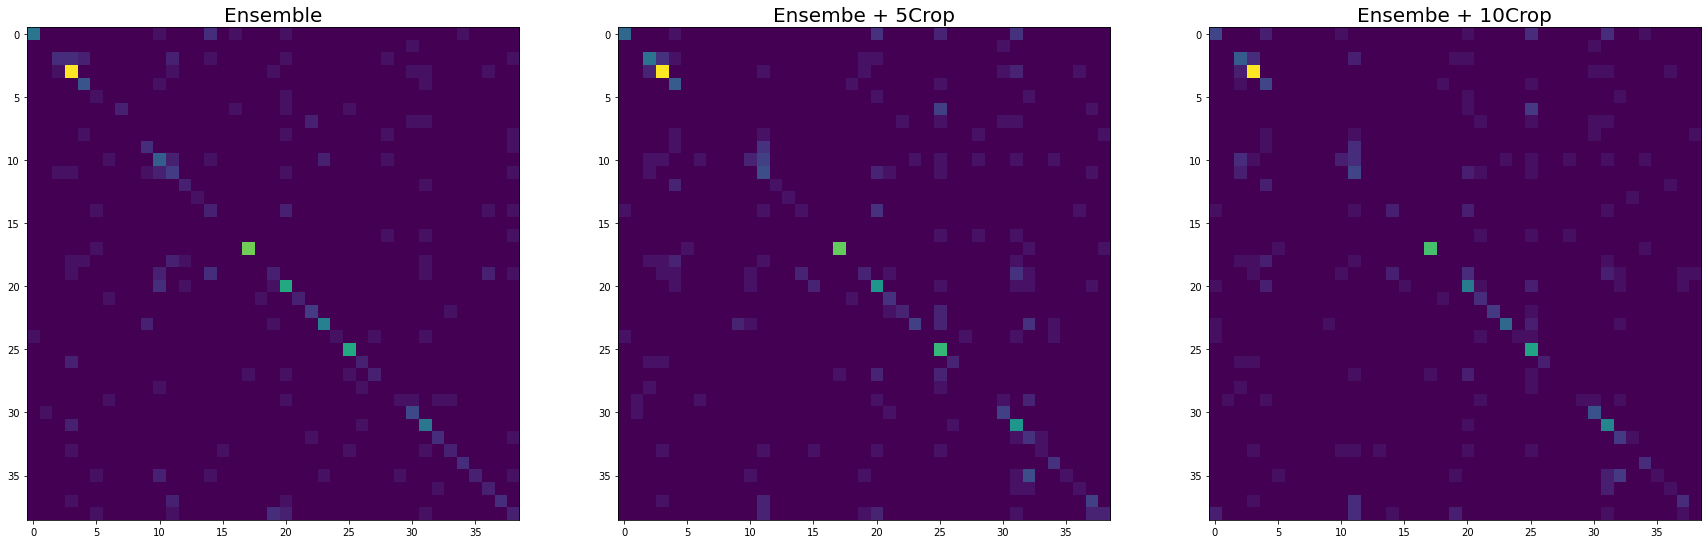

In [30]:
from IPython.display import Image
Image('confusion_matrices.png')

## Confusion Matrix Analysis.

We can use a confusion matrix to analyze the behavior of the model further. The results show a clear trend that predictive performance on the most commonly appearing classes is highest (fewer confusion), while the diagonal elements for the other classes are less defined. We can see that test-time data augmentation makes the diagonal trend less pronounced - the model is confused between more classes - for example look are the cluster of points around class 10. 



## Conclusion and Future Work

In this exercise I have taken a small dataset of fundus images and have trained a simple neural network model to predict eye diseases. This is a challenging dataset to learn for ML models due to the small number of training examples (1000) and the bias in the dataset towards a few classes which are overrepresented. I have applied a small model with aggressive data augmentation, small batch sizes and ensembling to yield an accuracy of 56%. 

However, this result can be further improved upon. Directions to explore for improving performance on this task are the following in order or decreasing priority:
- Using and adapting pre-trained models. This includes models trained on ImageNet, for example, as well as unsupervised pre-training schemes, such as Masked Autoencoder.
- Within the framework of pre-training, it would make sense to explore state-of-the-art architectures, such as vision transformers.
- Noisy-student training - obtain an unlabelled set of fundus images and label it using a model trained on this dataset. Then train a new model on the joint supervised and pseudo-labelled data.
- Explore more advanced forms of data augmentation.